In [1]:
import pandas as pd
import numpy as np
from time import ctime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Datos de entrenamiento limpios y con features agregados
train = pd.read_csv('../data/to_train_01.csv', low_memory=False, lineterminator='\n')

print(train.info())
train.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 86 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             260601 non-null  int64  
 1   damage_grade                            260601 non-null  int64  
 2   count_floors_pre_eq                     260601 non-null  int64  
 3   age                                     260601 non-null  int64  
 4   area_percentage                         260601 non-null  int64  
 5   height_percentage                       260601 non-null  int64  
 6   land_surface_condition                  260601 non-null  float64
 7   foundation_type                         260601 non-null  float64
 8   roof_type                               260601 non-null  float64
 9   ground_floor_type                       260601 non-null  float64
 10  other_floor_type                        2606

,building_id,damage_grade,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales\r
0,802906,3,2,30,6,5,2.234176,2.329448,2.269586,2.309002,...,0.16129,1.2,30,36,25,5.5,0.5,0.166667,0.2,2


In [3]:
# Datos de prueba
test = pd.read_csv('../data/to_test_01.csv', low_memory=False, lineterminator='\n')
print(test.info())
test.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 85 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   building_id                             86868 non-null  int64  
 1   count_floors_pre_eq                     86868 non-null  int64  
 2   age                                     86868 non-null  int64  
 3   area_percentage                         86868 non-null  int64  
 4   height_percentage                       86868 non-null  int64  
 5   land_surface_condition                  86868 non-null  float64
 6   foundation_type                         86868 non-null  float64
 7   roof_type                               86868 non-null  float64
 8   ground_floor_type                       86868 non-null  float64
 9   other_floor_type                        86868 non-null  float64
 10  position                                86868 non-null  fl

,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales\r
0,300051,3,20,7,6,2.234176,2.329448,2.269586,2.309002,2.315611,...,0.285714,1.166667,42,49,36,6.5,0.333333,0.142857,0.166667,1


## Entrenamiento del modelo

### Seleccion de features

In [4]:
def seleccion_de_features_to_remove(df_train):
    '''
    Funcion para seleccionar features.
    features_to_remove es la base que contiene building_id y damage_grade
    Las demas listas, las creamos y las agregamos a subset_features para luego appendearlas a features_to_remove
    '''
    features_to_remove = ['building_id', 'damage_grade']
    subset_features = []
    has_secondary = [col for col in df_train.columns if 'has_secondary' in col]
    legal_ownership = [col for col in df_train.columns if 'legal_ownership' in col]
    plan_configuration = [col for col in df_train.columns if 'plan_configuration' in col]
    probas = [col for col in df_train.columns if 'proba_danio' in col]
    relaciones_geo = [col for col in df_train.columns if 'relacion_' in col]
    cantidad_geo = [col for col in df_train.columns if 'cant_geolevel' in col]
    geo_level_embedded = [col for col in df_train.columns if 'geo_level_embedded_' in col]
    #subset_features.append(has_secondary)
    subset_features.append(cantidad_geo)
    subset_features.append(legal_ownership)
    subset_features.append(relaciones_geo)
    #subset_features.append(geo_level_embedded)
    subset_features.append(probas)
    #subset_features.append(plan_configuration)
    for subset in subset_features:
        features_to_remove += subset
    return features_to_remove

In [5]:
#features_adicionales_a_remover = ['proba_danio_1_dado_geolevel3', 'proba_danio_2_dado_geolevel3', 'proba_danio_3_dado_geolevel3']
#otras_features_a_sacar = ['has_superstructure_stone_flag', 'has_superstructure_other', 'has_superstructure_bamboo', 'has_superstructure_cement_mortar_stone',\
#      'has_superstructure_adobe_mud']

In [6]:
# Arreglo el nombre de la columna 'cant_materiales'
train.rename(columns={'cant_materiales\r': 'cant_materiales'}, inplace=True)
test.rename(columns={'cant_materiales\r': 'cant_materiales'}, inplace=True)

In [7]:
features_to_remove = seleccion_de_features_to_remove(train)
Y = train['damage_grade']
X = train.drop(features_to_remove, axis=1)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
# Como no es un arbol, necesitamos escalar los datos
# StandardScaler   -> promedio=0, desviacion estandar=1                       (cada feature)
# MinMaxScaler     -> escala valores de 0 a 1, (o rango pasado por parametro) (cada feature)
# RobustScaler     -> escala siendo robusto a outliers                        (cada feature)
# PowerTransformer -> modifica los datos para que tengan una gausiana         (cada feature)
# Normalizer       -> modifica los datos para que tengan norma=1              (cada fila)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1881, test_size=0.2)

> https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [12]:
from sklearn.metrics import f1_score

# No tiene tiempo de entrenamiento pero tarda demasiado al calcular la distancia de cada punto contra todos los otros puntos
# Coincide con lo visto en la teorica.
# Tarda aprox 40 min en predecir ambos test y train

# DD 0.7095
#Training Score: 0.7429
#Test Score:  0.7154

best_params = { 
    'n_jobs':-1,
    'n_neighbors': 15
}


print('Hora antes de empezar a tunear/entrenar: {}'.format(ctime()))
model = KNeighborsClassifier(**best_params)
model.fit(X_train, y_train)
print('Hora al finalizar de tunear/entrenar: {}'.format(ctime()))

# Vemos el score comprobando contra el set de test y de train
y_pred_test = model.predict(X_test)
model_f1_micro_test = f1_score(y_test, y_pred_test, average='micro')
y_pred_train = model.predict(X_train)
model_f1_micro_train = f1_score(y_train, y_pred_train, average='micro')
print('Training Score: %.4f' % model_f1_micro_train)
print('Test Score:  %.4f' % model_f1_micro_test)

Hora antes de empezar a tunear/entrenar: Sun Jul 25 22:41:11 2021
Hora al finalizar de tunear/entrenar: Sun Jul 25 22:41:11 2021
Training Score: 0.7429
Test Score:  0.7154


La matriz de confusion nos muestra nuestros $tp$, $fp$, $tn$ y $fn$ en una matriz. La diagonal principal son los valores correctamente clasificados. Los otros valores indican la cantidad de puntos mal clasificados.
> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [13]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('default')
sns.set(style='whitegrid') # seteando tipo de grid en seaborn

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title('Matriz de confusion')
    sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, fmt='g', square=True)
    plt.ylabel('Label correcto')
    plt.xlabel('Label predecido')
    plt.show()

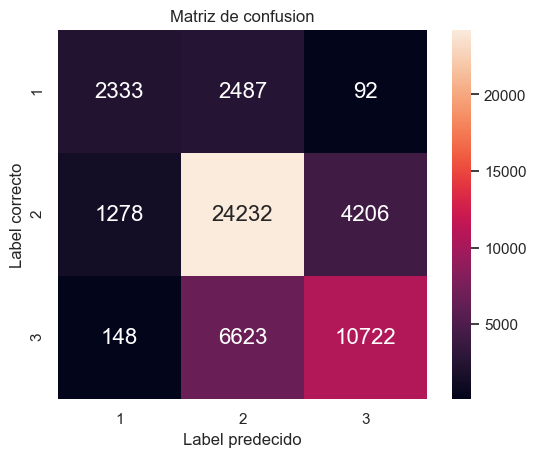

In [14]:
plot_confusion_matrix(y_test, y_pred_test)

### Prediccion del modelo

In [15]:
# Saco damage_grade de las features a remover ya que dicha feature NO esta en el set de test
features_to_remove.remove('damage_grade')
to_test = test.drop(features_to_remove, axis=1)

In [16]:
to_test = scaler.fit_transform(to_test)

In [17]:
# Tarda 14 min aprox.
y_pred = model.predict(to_test)
y_pred

array([2, 2, 2, ..., 2, 2, 1], dtype=int64)

### Formateo de la prediccion para un submit

In [18]:
test_id = test['building_id']
test_id

0         300051
1          99355
2         890251
3         745817
4         421793
          ...   
86863     310028
86864     663567
86865    1049160
86866     442785
86867     501372
Name: building_id, Length: 86868, dtype: int64

In [19]:
submit = pd.concat([test_id, pd.Series(y_pred, name='damage_grade')], axis=1)
submit.set_index('building_id', inplace=True)
submit.head()

,damage_grade
building_id,
300051,2
99355,2
890251,2
745817,2
421793,3


In [20]:
submit.to_csv('../submits-csv/submit-KNN-{}.csv'.format(model_f1_micro_test))